# Dataset Description
The dataset for this competition (both train and test) was generated 
from a deep learning model trained on the Concrete Strength Prediction dataset. 
Feature distributions are close to, but not exactly the same, as the original. 

# Installation and importing of necessary libraries

In [1]:
# Import necessary libraries and functions
import os
os.system("pip3 install lazypredict > /dev/null 2>&1")
# basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint as sp_randint
plt.style.use('ggplot')
%matplotlib inline
import lazypredict
from lazypredict.Supervised import LazyRegressor
from scipy.stats import randint as sp_randint

# sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import HuberRegressor, PassiveAggressiveRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor

# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense



# EDA


## Loading datasets

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s3e9/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e9/test.csv')
print('Train set shape:',train.shape)
print('Test set shape:',test.shape)

Train set shape: (5407, 10)
Test set shape: (3605, 9)


In [3]:
train.describe()

,id,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
count,5407.00,5407.00,5407.00,5407.00,5407.00,5407.00,5407.00,5407.00,5407.00,5407.00
mean,2703.00,299.17,58.61,31.87,185.08,4.11,992.00,771.22,51.75,35.45
std,1561.01,105.54,83.42,54.61,18.52,5.69,77.15,78.73,70.01,16.40
min,0.00,102.00,0.00,0.00,121.80,0.00,801.00,594.00,1.00,2.33
25%,1351.50,213.70,0.00,0.00,175.10,0.00,938.20,734.30,7.00,23.64
50%,2703.00,297.20,0.00,0.00,187.40,0.00,978.00,781.20,28.00,33.95
75%,4054.50,375.00,122.60,79.00,192.00,8.05,1047.00,821.00,56.00,45.85
max,5406.00,540.00,359.40,200.10,247.00,32.20,1145.00,992.60,365.00,82.60


## Analyzing missing data in the datasets

In [4]:
print('Train missing data:',train.isna().sum(),'\n', 'Test missing data:',test.isna().sum())

Train missing data: id                           0
CementComponent              0
BlastFurnaceSlag             0
FlyAshComponent              0
WaterComponent               0
SuperplasticizerComponent    0
CoarseAggregateComponent     0
FineAggregateComponent       0
AgeInDays                    0
Strength                     0
dtype: int64 
 Test missing data: id                           0
CementComponent              0
BlastFurnaceSlag             0
FlyAshComponent              0
WaterComponent               0
SuperplasticizerComponent    0
CoarseAggregateComponent     0
FineAggregateComponent       0
AgeInDays                    0
dtype: int64


Insight - no missing data in the dataset.

## Concatenating train and test datasets

In [5]:
complete = pd.concat([test.assign(ind="test"), train.assign(ind="train")]) ## assigning markers for the test and train sets
complete.reset_index(level=0, inplace=True)
complete.head()

,index,id,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,ind,Strength
0,0,5407,166.10,75.40,163.80,173.80,4.60,1007.20,746.60,56,test,NaN
1,1,5408,304.00,0.00,0.00,190.00,0.00,998.00,801.00,7,test,NaN
2,2,5409,225.00,0.00,0.00,185.00,0.00,1113.00,833.00,28,test,NaN
3,3,5410,251.40,0.00,118.30,188.50,6.40,1028.40,757.70,100,test,NaN
4,4,5411,144.00,15.00,195.00,176.00,6.00,1021.00,709.00,28,test,NaN


## Analysing distributions of numeric and continuous features

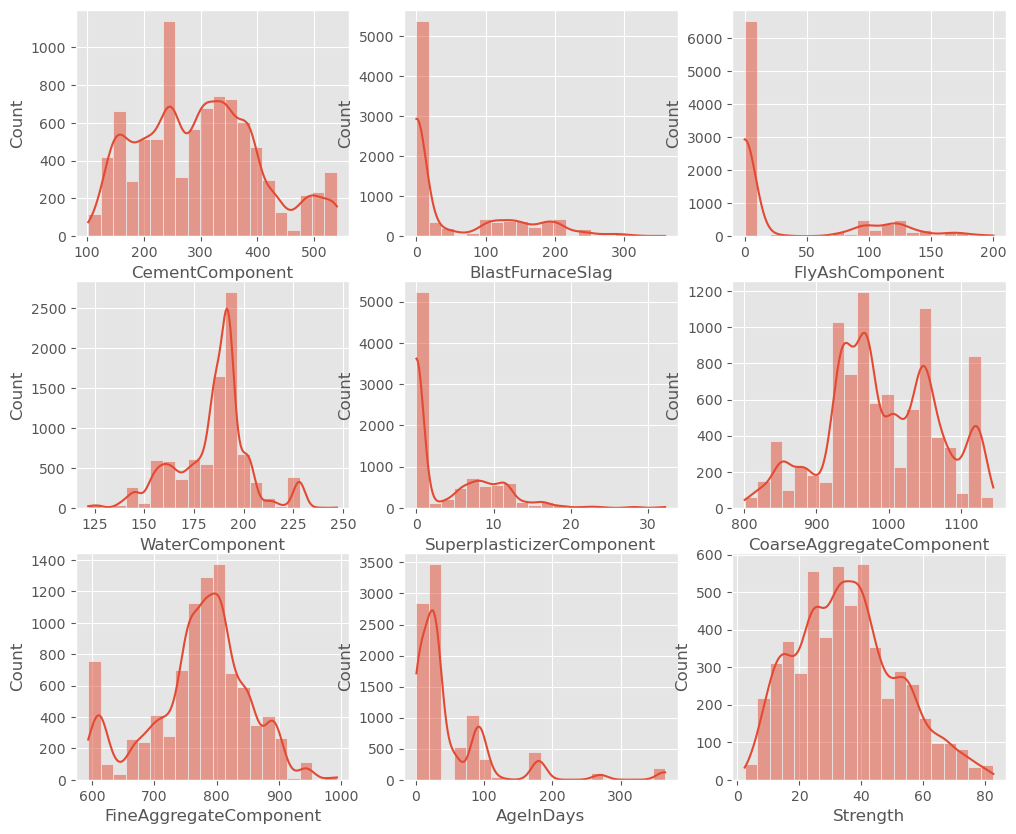

In [6]:
continious_features=["CementComponent",
"BlastFurnaceSlag",
"FlyAshComponent",
"WaterComponent",
"SuperplasticizerComponent",
"CoarseAggregateComponent",
"FineAggregateComponent",
"AgeInDays",
"Strength"  ]

# Plot expenditure features
fig=plt.figure(figsize=(12,10))
for i, var_name in enumerate(continious_features):
    ax=fig.add_subplot(3,3,i+1)
    sns.histplot(data=complete, x=var_name, bins=20, kde=True, alpha = 0.5)   

plt.show()

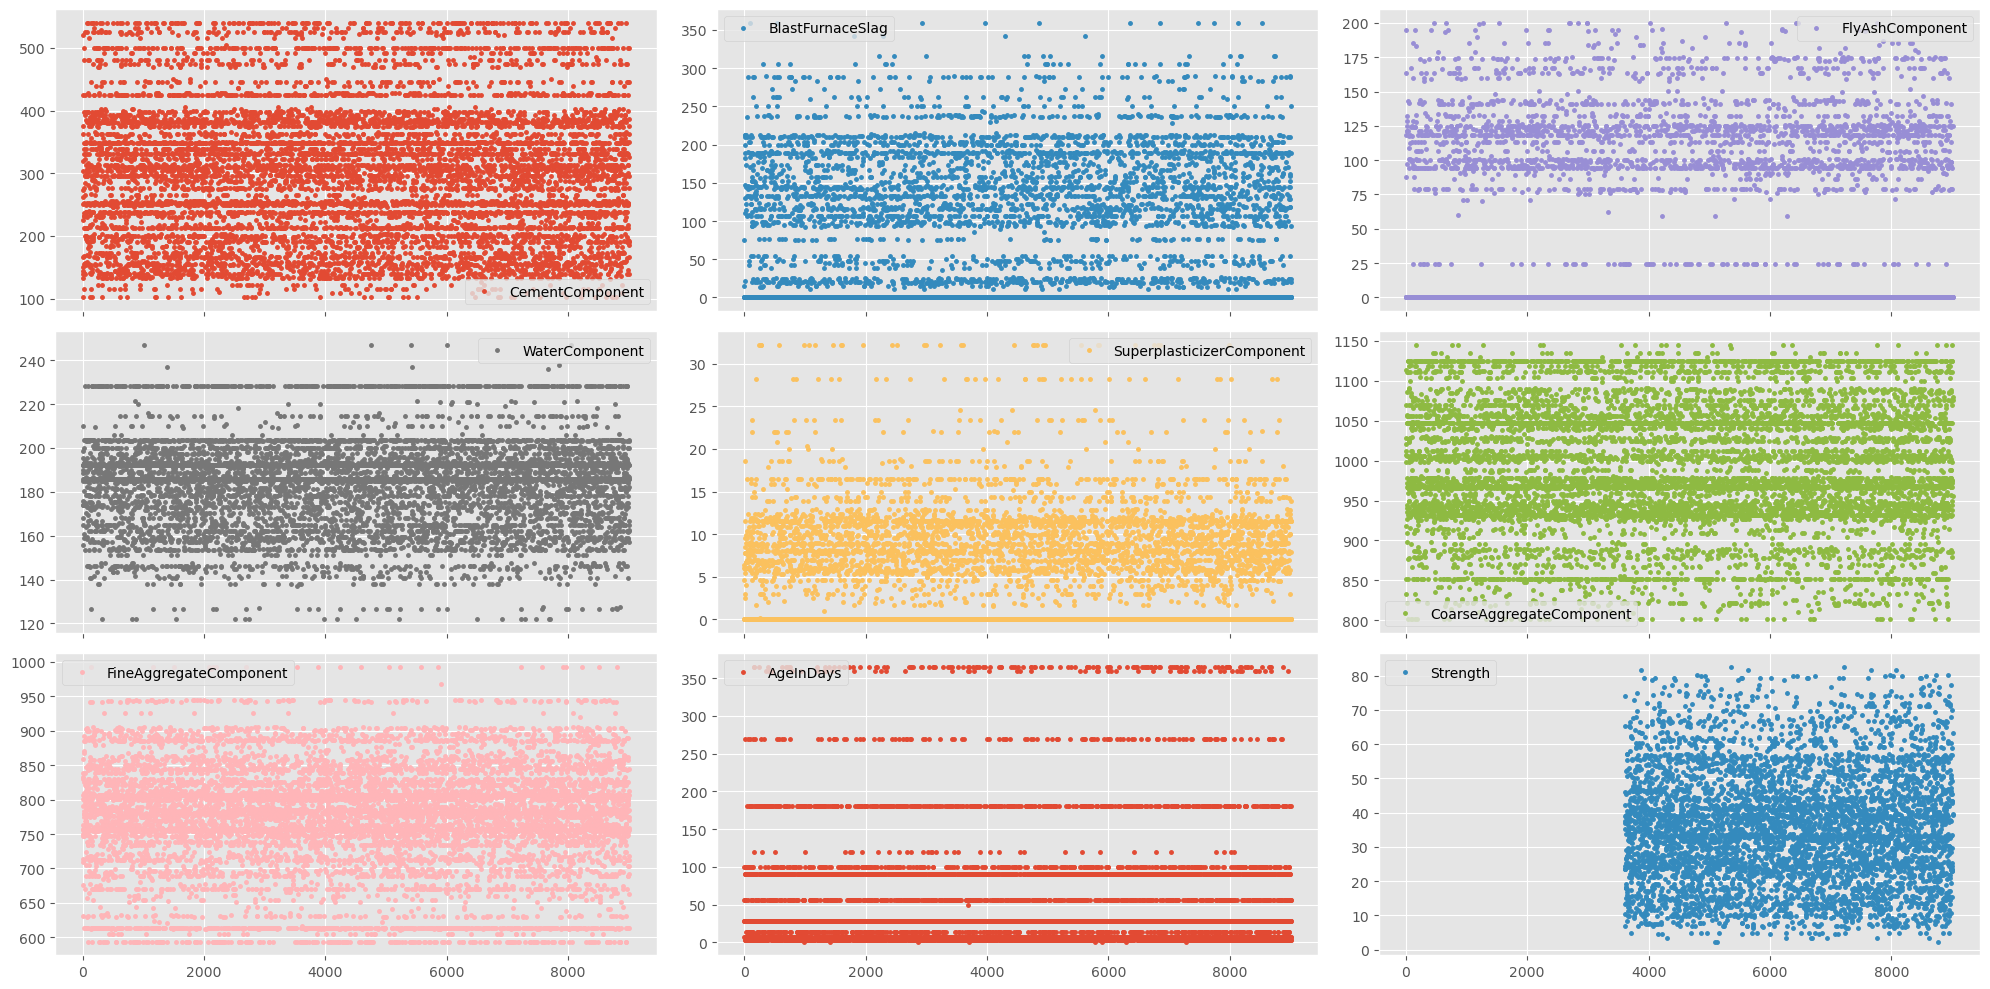

In [7]:
complete[continious_features].plot(lw=0, marker=".", subplots=True, layout=(-1, 3),
          figsize=(20,10), markersize=5)
plt.tight_layout()

Insight - no extraordinary outliers present in the dataset. All varaibles seem to represent continuous features - not factors.

# Scaling the data

In [8]:
# Determining the list of features to scale by combining continious_features and numeric_features lists
features_to_scale = continious_features
features_to_scale.remove('Strength') # Remove target variable

print(features_to_scale)

# Creating an instance of StandardScaler() class from scikit-learn library
scaler = StandardScaler()

# Scaling the features in "complete" dataframe using StandardScaler() and creating a new dataframe with "_scaled" suffix
scaled_features = pd.DataFrame(scaler.fit_transform(complete[features_to_scale]), columns = [name + '_scaled' for name in features_to_scale])

# Concatenating the scaled features dataframe with the original dataframe, and dropping the original unscaled columns
scaled_complete = pd.concat([complete, scaled_features], axis = 1)
scaled_complete.drop(columns = features_to_scale, inplace = True)

# Dropping 'index', 'id', and 'cityCode' columns, and moving 'price' column to the beginning of the dataframe
scaled_complete.drop(columns = ['index', 'id'], inplace = True)
scaled_complete.insert(0, 'Strength', scaled_complete.pop('Strength'))

['CementComponent', 'BlastFurnaceSlag', 'FlyAshComponent', 'WaterComponent', 'SuperplasticizerComponent', 'CoarseAggregateComponent', 'FineAggregateComponent', 'AgeInDays']


In [9]:
scaled_complete.head()

,Strength,ind,CementComponent_scaled,BlastFurnaceSlag_scaled,FlyAshComponent_scaled,WaterComponent_scaled,SuperplasticizerComponent_scaled,CoarseAggregateComponent_scaled,FineAggregateComponent_scaled,AgeInDays_scaled
0,NaN,test,-1.27,0.22,2.39,-0.60,0.08,0.21,-0.33,0.08
1,NaN,test,0.04,-0.70,-0.59,0.29,-0.72,0.09,0.36,-0.65
2,NaN,test,-0.71,-0.70,-0.59,0.01,-0.72,1.58,0.77,-0.34
3,NaN,test,-0.46,-0.70,1.57,0.20,0.39,0.48,-0.19,0.73
4,NaN,test,-1.48,-0.52,2.96,-0.48,0.32,0.39,-0.81,-0.34


# Correlation of variables

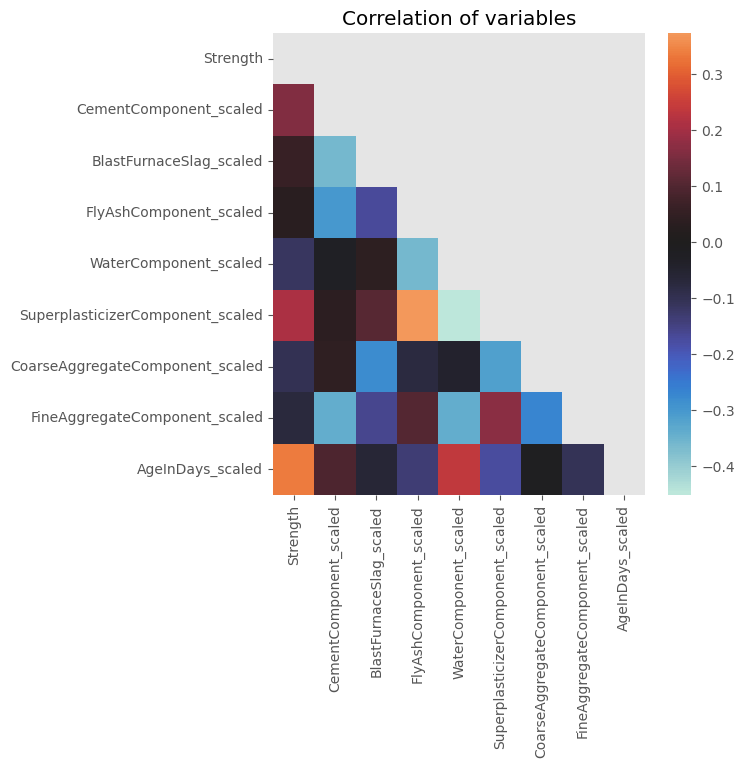

In [10]:
plt.figure(figsize = (6,6))
corr = scaled_complete.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask = mask, robust = True,center = 0,square = False) ## building correlation matrix
plt.title('Correlation of variables')
plt.show()

Insight - even though some of the variables have not significant Pearson correlation with the target variable, they seem to be strongly correlated with the others. Therefore we will go on with all the variables present for our model.

# Splitting datasets back to train and test. Creating train / validation splits

In [11]:
test_scaled, train_scaled = scaled_complete[scaled_complete["ind"].eq("test")], scaled_complete[scaled_complete["ind"].eq("train")]
train_scaled.drop('ind', axis = 1, inplace = True)
test_scaled.drop('ind', axis = 1, inplace = True)
y_train, X_train, X_test = train_scaled["Strength"],  \
train_scaled.loc[:, train_scaled.columns != 'Strength'],\
train_scaled.loc[:, test_scaled.columns != 'Strength']

In [12]:
X_train, X_val, y_train, y_val = \
train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Models from Lazy Regressor

In [13]:
reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None, random_state=42, 
                          regressors = lazypredict.Supervised.REGRESSORS[:30] + lazypredict.Supervised.REGRESSORS[32:]) 
## we exclude model 31 from the call because of the problems in the functionality of this call in lazypredictor at the moment
models,predictions = reg.fit(X_train, X_val, y_train, y_val)

'tuple' object has no attribute '__name__'
Invalid Regressor(s)


100%|██████████| 40/40 [00:22<00:00,  1.81it/s]


In [14]:
print(models.head(10))

                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
GradientBoostingRegressor                    0.49       0.49 11.78        0.50
MLPRegressor                                 0.48       0.48 11.90        7.93
HistGradientBoostingRegressor                0.47       0.47 11.99        0.53
LGBMRegressor                                0.46       0.47 12.05        0.91
AdaBoostRegressor                            0.43       0.44 12.39        0.09
RandomForestRegressor                        0.42       0.42 12.56        1.50
XGBRegressor                                 0.41       0.41 12.66        0.82
BaggingRegressor                             0.37       0.38 13.02        0.16
ExtraTreesRegressor                          0.37       0.38 13.03        0.88
SVR                                          0.37       0.37 13.05        1.46


# Hyperparameter tuning for the best baseline model for the dataset - GradientBoostingRegressor     

## Initializing random grid search

In [15]:

# Create a GradientBoostingRegressor model
model = GradientBoostingRegressor()

# Define the hyperparameters and their ranges
hyperparameters = {
    'n_estimators': [25, 50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [2, 3, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt'],
    'loss': ['ls', 'lad', 'huber', 'quantile'],
    'alpha': [0.1, 0.5]
}

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(model, hyperparameters, cv=5, n_iter=20, n_jobs=-1, random_state=42)

# Fit the RandomizedSearchCV object to the data
random_search.fit(X_train, y_train)
y_predict = random_search.predict(X_val)
# Print the best hyperparameters and their corresponding score
print("Best hyperparameters: ", random_search.best_params_)
print('Best validation RMSE score:', 
      mean_squared_error(y_val, y_predict, squared=False))

Best hyperparameters:  {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 2, 'loss': 'quantile', 'learning_rate': 0.1, 'alpha': 0.5}
Best validation RMSE score: 11.964603621021677


## Visualizing of the results

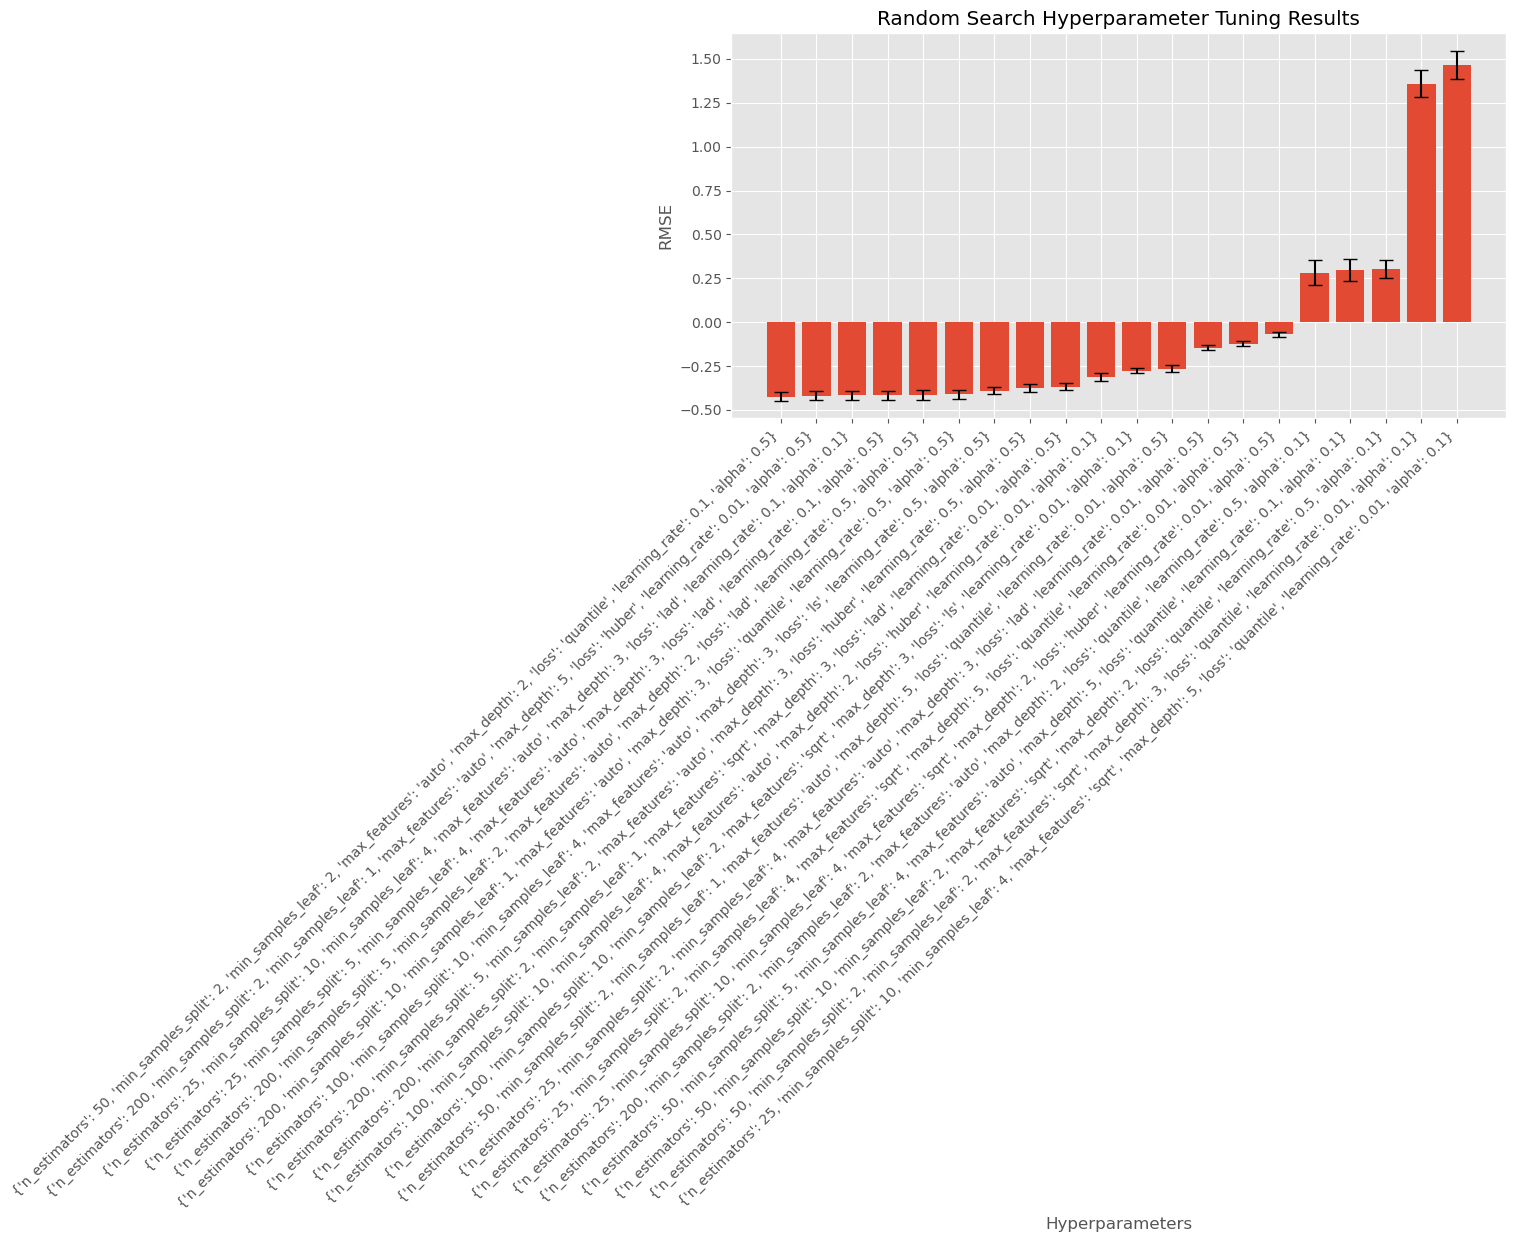

In [16]:
results = random_search.cv_results_

# Extract the relevant information
params = [str(p) for p in results['params']]
mean_scores = -results['mean_test_score']
std_scores = results['std_test_score']

# Sort the hyperparameter combinations by RMSE score
sorted_idx = mean_scores.argsort()
params = [params[i] for i in sorted_idx]
mean_scores = mean_scores[sorted_idx]
std_scores = std_scores[sorted_idx]

# Create a bar chart
plt.figure(figsize=(10, 5))
plt.bar(params, mean_scores, yerr=std_scores, capsize=5)

# Set the chart title and axis labels
plt.title("Random Search Hyperparameter Tuning Results")
plt.xlabel("Hyperparameters")
plt.ylabel("RMSE")

# Rotate the x-axis labels for readability
plt.xticks(rotation=45, ha='right')

# Show the chart
plt.show()

## Adopting the result of best performers for the final grid search

In [17]:
model_final = GradientBoostingRegressor()

# Define the hyperparameters and their ranges
hyperparameters = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1],
    'max_depth': [2, 3],
    'min_samples_split': [15, 20],
    'min_samples_leaf': [3, 4],
    'max_features': ['auto'],
    'loss': ['ls'],
    'alpha': [0.1],
    'random_state': [42]
}

# Create a GridSearchCV object
grid_search_final = GridSearchCV(model, hyperparameters, cv=5, n_jobs=-1)

# Fit the GridSearchCV object to the data
grid_search_final.fit(X_train, y_train)
y_predict_final = grid_search_final.predict(X_val)
# Print the best hyperparameters and their corresponding score
print("Best hyperparameters: ", grid_search_final.best_params_)
print('Best validation RMSE score:', 
      mean_squared_error(y_val, y_predict_final, squared=False))

Best hyperparameters:  {'alpha': 0.1, 'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 20, 'n_estimators': 100, 'random_state': 42}
Best validation RMSE score: 11.858249349897921


Best hyperparameters:  {'alpha': 0.1, 'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 15, 'n_estimators': 100, 'random_state': 42}
Best validation RMSE score: 11.843093699318986

# Keras Tensorflow Regressor

In [18]:
def create_model(neurons=128, learning_rate=0.01, activation1='relu', activation2='relu'):
    # Create an Adam optimizer with the given learning rate
    opt = Adam(lr=learning_rate)
  
    # Create your regression model  
    model = Sequential()
    model.add(Dense(neurons, input_shape=X_train.shape[1:], activation=activation1, kernel_initializer='normal'))
    model.add(Dense(neurons // 2, activation=activation2, kernel_initializer='normal'))
    model.add(Dense(1, activation=None, kernel_initializer='normal'))

    # Compile your model with your optimizer, loss, and metrics
    model.compile(optimizer=opt, loss='mean_squared_error', metrics=['mean_absolute_error'])
  
    return model

# Create a KerasRegressor
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the parameters to try out
params = {
    'neurons': [16,32,64,128,256],
    'activation1': ['tanh','relu', 'sigmoid'],
    'activation2': ['tanh','relu', 'sigmoid'], 
    'batch_size': [16, 32, 64],
    'learning_rate': [0.01, 0.001, 0.0001]
}

# Create a randomized search CV object passing in the parameters to try
random_search_keras = RandomizedSearchCV(model, param_distributions=params, n_iter=10, cv=3, verbose=0)

# Set up early stopping based on validation loss
monitor_val_loss = EarlyStopping(monitor='val_loss', patience=3)

# Fit the object to our data
random_search_keras.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val),
                        callbacks=[monitor_val_loss])


# Evaluate the final model on the testing set
y_predict_keras = random_search_keras.predict(X_val)
test_score_keras = random_search_keras.score(X_val, y_val)
print('Best validation RMSE score:', mean_squared_error(y_val, y_predict_keras, squared=False))
print('Best hyperparameters:', random_search_keras.best_params_)

Best validation RMSE score: 12.503573299688323
Best hyperparameters: {'neurons': 256, 'learning_rate': 0.001, 'batch_size': 16, 'activation2': 'sigmoid', 'activation1': 'sigmoid'}


The score of the neural network is slightly weaker on this dataset.

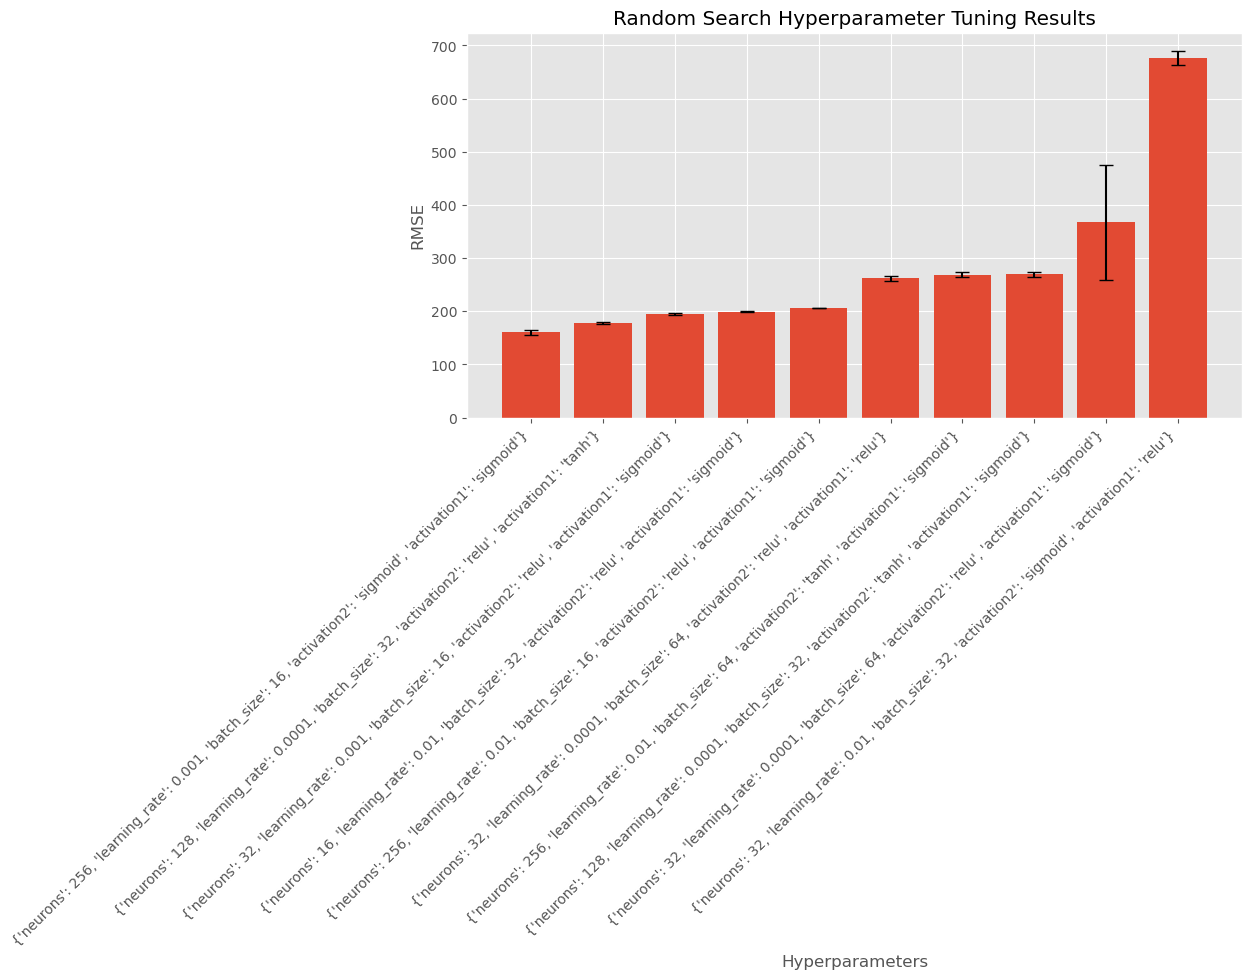

In [19]:
results_keras = random_search_keras.cv_results_

# Extract the relevant information
params = [str(p) for p in results_keras['params']]
mean_scores = -results_keras['mean_test_score']
std_scores = results_keras['std_test_score']

# Sort the hyperparameter combinations by RMSE score
sorted_idx = mean_scores.argsort()
params = [params[i] for i in sorted_idx]
mean_scores = mean_scores[sorted_idx]
std_scores = std_scores[sorted_idx]

# Create a bar chart
plt.figure(figsize=(10, 5))
plt.bar(params, mean_scores, yerr=std_scores, capsize=5)

# Set the chart title and axis labels
plt.title("Random Search Hyperparameter Tuning Results")
plt.xlabel("Hyperparameters")
plt.ylabel("RMSE")

# Rotate the x-axis labels for readability
plt.xticks(rotation=45, ha='right')

# Show the chart
plt.show()

In [20]:
def create_model(neurons=128, learning_rate=0.01, activation1='relu', activation2='relu', random_state=42):
    # Create an Adam optimizer with the given learning rate
    opt = Adam(lr=learning_rate)
  
    # Create your regression model  
    model = Sequential()
    model.add(Dense(neurons, input_shape=X_train.shape[1:], activation=activation1, kernel_initializer='normal'))
    model.add(Dense(neurons // 2, activation=activation2, kernel_initializer='normal'))
    model.add(Dense(1, activation=None, kernel_initializer='normal'))

    # Compile your model with your optimizer, loss, and metrics
    model.compile(optimizer=opt, loss='mean_squared_error', metrics=['mean_absolute_error'])
  
    return model

# Create a KerasRegressor
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the parameters to try out
params = {
    'neurons': [128, 256],
    'activation1': ['relu', 'tanh'],
    'activation2': ['relu'], 
    'batch_size': [8, 16],
    'learning_rate': [0.01, 0.001]
}

# Create a grid search CV object passing in the parameters to try
grid_search_keras = GridSearchCV(model, param_grid=params, cv=5, verbose=0)

# Set up early stopping based on validation loss
monitor_val_loss = EarlyStopping(monitor='val_loss', patience=3)

# Fit the object to our data
grid_search_keras.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val),
                        callbacks=[monitor_val_loss])


# Evaluate the final model on the testing set
y_predict_keras = grid_search_keras.predict(X_val)
test_score_keras = grid_search_keras.score(X_val, y_val)
print('Best validation RMSE score:', mean_squared_error(y_val, y_predict, squared=False))
print('Best hyperparameters:', grid_search_keras.best_params_)

Best validation RMSE score: 11.964603621021677
Best hyperparameters: {'activation1': 'tanh', 'activation2': 'relu', 'batch_size': 16, 'learning_rate': 0.01, 'neurons': 128}


The score is still a bit weaker than of GradientBoostingRegressor. The fitting time for Keras Tensorflow at least without TPU is a lot less efficient as well

# Final prediction and submission

In [21]:
test_scaled.drop(["Strength"], axis = 1, inplace = True)
preds = grid_search_final.predict(test_scaled)
test['Strength'] = preds
submission = test[['id','Strength']]
submission.to_csv('submission.csv', index = False)

# Final thoughts

The final place of this notebook is 84 out of 765. 

This notebook was generated within 2 hours based on another my notebook (https://www.kaggle.com/code/nikoolaylovyagin/playground-series)
The generated pipeline seems to be an appropriate baseline for at least these two datasets and might be considered applicable starting framework for other Regression tasks.